<a href="https://colab.research.google.com/github/Rene-Castillo-21/Proyecto-2-Filtros-sobre-Imagenes/blob/main/Proyecto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Configuración Inicial y Carga de Bibliotecas

Importamos las bibliotecas necesarias para:
- Manipulación de imágenes (OpenCV, PIL)
- Procesamiento numérico (NumPy)
- Manejo de archivos (os, shutil)
- Construcción y entrenamiento de modelos (TensorFlow/Keras)
- Visualización (matplotlib)


In [ ]:
# Configuración inicial
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## 2. Preprocesamiento de Imágenes

Funciones para:
- Aplicar filtros y transformaciones a las imágenes
- Convertir imágenes a escala de grises
- Normalizar valores de píxeles
- Guardar imágenes procesadas

In [ ]:
def aplicar_filtros_imagen(imagen, filtro=None, kernel=None):
    """
    Aplica filtros y transformaciones a una imagen
    Opciones de filtro: 'blur', 'sobel', 'custom'
    """
    if filtro is None:
        return imagen

    if filtro == "blur":
        return cv2.GaussianBlur(imagen, (5, 5), 0)

    if filtro == "sobel":
        # Detección de bordes con Sobel
        sobel_x = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        return cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    if filtro == "custom" and kernel is not None:
        return cv2.filter2D(imagen, -1, kernel)

    return imagen

def procesar_guardar_imagen(ruta_origen, ruta_destino, filtro=None, kernel=None):
    """
    Procesa y guarda imágenes aplicando:
    1. Conversión a escala de grises
    2. Normalización
    3. Aplicación de filtros
    4. Guardado en formato JPG
    """
    try:
        with Image.open(ruta_origen).convert('L') as img:
            img_array = np.array(img)

            # Normalización
            if img_array.max() > 1.0:
                img_array = img_array.astype(np.uint8)
            else:
                img_array = (img_array * 255).astype(np.uint8)

            # Aplicar filtro
            img_procesada = aplicar_filtros_imagen(img_array, filtro, kernel)

            # Guardar imagen procesada
            Image.fromarray(img_procesada).save(ruta_destino, "JPEG")
    except Exception as e:
        print(f"Error procesando {os.path.basename(ruta_origen)}: {e}")

## 3. Creación de Conjuntos de Datos

Organizamos las imágenes en directorios para:
- Entrenamiento (80%)
- Validación (10%)
- Prueba (10%)

In [ ]:
def crear_estructura_directorios(ruta_base, categorias):
    """Crea la estructura de directorios para el dataset"""
    os.makedirs(ruta_base, exist_ok=True)

    for split in ['train', 'validation', 'test']:
        for categoria in categorias:
            os.makedirs(os.path.join(ruta_base, split, categoria), exist_ok=True)

def dividir_dataset(ruta_origen, ruta_destino, categorias, ratio_val=0.1, ratio_test=0.1):
    """
    Divide el dataset en train/val/test
    Args:
        ratio_val: Porcentaje para validación (0-1)
        ratio_test: Porcentaje para prueba (0-1)
    """
    crear_estructura_directorios(ruta_destino, categorias)

    for categoria in categorias:
        ruta_categoria = os.path.join(ruta_origen, categoria)
        imagenes = [f for f in os.listdir(ruta_categoria) if os.path.isfile(os.path.join(ruta_categoria, f))]

        # Dividir en train/test/val
        train, test = train_test_split(imagenes, test_size=ratio_test)
        train, val = train_test_split(train, test_size=ratio_val/(1-ratio_test))

        # Copiar archivos
        for split, grupo in zip(['train', 'validation', 'test'], [train, val, test]):
            for img in grupo:
                origen = os.path.join(ruta_categoria, img)
                destino = os.path.join(ruta_destino, split, categoria, os.path.splitext(img)[0] + '.jpg')
                procesar_guardar_imagen(origen, destino)

## 4. Data Augmentation

Técnicas utilizadas para aumentar la diversidad del dataset:
- Rotaciones pequeñas (±5 grados)
- Desplazamientos horizontales/verticales (5%)
- Zoom (5%)
- Ajuste de brillo (90-110%)
- Shear (2%)

In [ ]:
# Configurar generadores de datos
def crear_generadores(ruta_dataset, target_size=(150, 150), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        brightness_range=[0.9, 1.1],
        shear_range=0.02,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(ruta_dataset, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=True
    )

    val_gen = test_datagen.flow_from_directory(
        os.path.join(ruta_dataset, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False
    )

    test_gen = test_datagen.flow_from_directory(
        os.path.join(ruta_dataset, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

## 5. Construcción del Modelo CNN

Propuesta:
- 4 Bloques Conv2D + MaxPooling
- Capa Flatten
- Dropout para regularización
- 2 Capas Dense finales

Hiperparámetros:
- Optimizador: RMSprop (lr=1e-4)
- Función de pérdida: Binary Crossentropy
- Early Stopping para prevenir overfitting

In [ ]:
def construir_modelo(input_shape=(150, 150, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.3),

        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(learning_rate=1e-4),
        metrics=['acc']
    )

    return model

## 6. Entrenamiento y Evaluación

Configuración de entrenamiento:
- Early Stopping: Detiene el entrenamiento si no hay mejora en val_loss por 10 epochs
- 120 epochs máximas
- Batch size: 32

Métricas a monitorear:
- Precisión (accuracy)
- Pérdida (loss)

In [ ]:
def entrenar_modelo(model, train_gen, val_gen, epochs=120):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // train_gen.batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=val_gen.samples // val_gen.batch_size,
        callbacks=[early_stopping]
    )

    return history

## 7. Visualización de Resultados

Gráficos para analizar:
- Evolución de accuracy en entrenamiento/validación
- Evolución de loss en entrenamiento/validación

Estos gráficos ayudan a diagnosticar:
- Overfitting (validación divergente de entrenamiento)
- Underfitting (poca capacidad de aprendizaje)
- Convergencia adecuada

In [ ]:
def visualizar_resultados(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'b', label='Validación')
    plt.title('Precisión en Entrenamiento y Validación')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'b', label='Validación')
    plt.title('Pérdida en Entrenamiento y Validación')
    plt.legend()

    plt.show()

## Flujo de Ejecución Principal

Pasos para ejecutar todo el proceso:
1. Montar Google Drive
2. Configurar rutas
3. Preprocesar y dividir dataset
4. Crear generadores de datos
5. Construir y entrenar modelo
6. Evaluar resultados
7. Hacer predicciones

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 237 images belonging to 2 classes.
Found 71 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - acc: 0.5522 - loss: 0.6906 - val_acc: 0.5469 - val_loss: 0.6656
Epoch 2/120
1/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - acc: 0.5000 - loss: 0.6805

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - acc: 0.5000 - loss: 0.6805 - val_acc: 0.8125 - val_loss: 0.6617
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.6315 - loss: 0.6753 - val_acc: 0.8750 - val_loss: 0.6337
Epoch 4/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - acc: 0.7812 - loss: 0.6557 - val_acc: 0.7344 - val_loss: 0.6277
Epoch 5/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.7057 - loss: 0.6466 - val_acc: 0.7500 - val_loss: 0.5744
Epoch 6/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - acc: 0.5938 - loss: 0.6424 - val_acc: 0.7812 - val_loss: 0.5683
Epoch 7/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - acc: 0.6349 - loss: 0.6244 - val_acc: 0.7031 - val_loss: 0.5358
Epoch 8/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - acc: 0.8462 - loss: 0.5415 - val_acc: 0.7344 - val_loss: 0.5334
Epoch 9/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.6846 - loss: 0.6214 - val_acc: 0.7812 - val_loss: 0.5418
Epoch 10/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - acc: 0.7692 - loss: 0.5039 - v

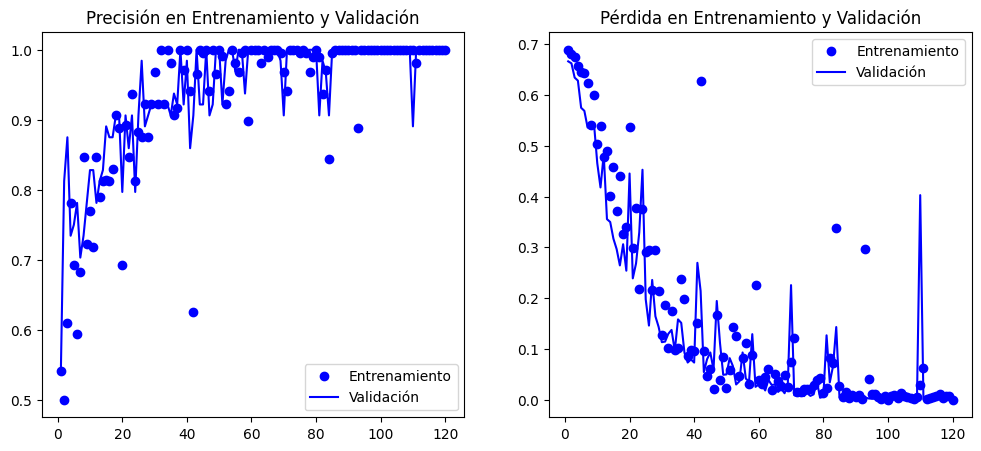

In [ ]:
if __name__ == "__main__":
    # Configurar rutas
    drive.mount('/content/drive')
    ruta_dataset_original = "/content/drive/MyDrive/modulo 5/piedras en los riñones"
    ruta_dataset_procesado = "/content/drive/MyDrive/modulo 5/conjunto_datos_procesado"

    # Preprocesar y dividir dataset
    dividir_dataset(
        ruta_origen=ruta_dataset_original,
        ruta_destino=ruta_dataset_procesado,
        categorias=['yes', 'no'],
        ratio_val=0.1,
        ratio_test=0.1
    )

    # Crear generadores de datos
    train_gen, val_gen, test_gen = crear_generadores(ruta_dataset_procesado)

    # Construir y entrenar modelo
    model = construir_modelo()
    history = entrenar_modelo(model, train_gen, val_gen)

    # Evaluar modelo
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"\nPrecisión en prueba: {test_acc:.2%}")
    print(f"\nPérdida en prueba: {test_loss:.2%}")

    # Visualizar resultados
    visualizar_resultados(history)

#**Justificación del Filtro Sobel para Preprocesamiento de Imágenes Médicas**

### Se implementó principalmente el filtro Sobel para el preprocesamiento de las imágenes de piedras renales. Este filtro se aplica cuando se selecciona la opción `'sobel'` en la función `aplicar_filtros_imagen()`. Las principales razones para usar dicho filtro son:


1.   **Destacar bordes y estructuras anatómicas:**
   - Resalta cambios abruptos de intensidad (bordes)
   - Marca transiciones entre tejidos de diferente densidad
   - Enfatiza contornos de cálculos renales

2.   **Datos relevantes:**
Los cálculos renales suelen presentar:
     - Bordes bien definidos
     - Alto contraste con tejidos circundantes
     - Geometrías características

3. **Comparativa con Otros Filtros**

| Filtro         | Ventajas                     | Desventajas para este Caso          |
|----------------|------------------------------|--------------------------------------|
| **Sobel**      | Destaca bordes preservando estructura | Sensible a ruido moderado       |
| **Gaussiano**  | Reduce ruido eficazmente     | Difumina detalles finos críticos    |
| **Laplaciano** | Enfatiza bordes finos        | Genera artefactos con ruido         |


###Por lo tanto, al aplicar el Sobel, obtenemos:
  - Mejor contraste entre cálculos y tejido sano

  - Reducción de falsos positivos por variaciones sutiles

  - Mayor precisión en la clasificación binaria (piedra/no piedra)

